In [28]:

%matplotlib inline
from pipeline import Pipeline
from decoding_analysis import *
from erpanalysis import ERPAnalysis
from preprocessing import *
from mne_bids import BIDSPath
import matplotlib.pyplot as plt

import os

In [2]:


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

from mne.decoding import Vectorizer

from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

## Set BIDSPath

In [3]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',
                        datatype='eeg', suffix='eeg', root=bids_root)

## Initialize Pipeline and execute init actions

In [4]:
pipeline = Pipeline(bids_path, verbose=logging.ERROR)
pipeline.load_data()
pipeline.set_custom_events_mapping(task='P3')
pipeline.set_montage()

We will initialize an object of `ERPAnalysis` which will have all the data regarding the ERP analysis, we will also run the pipeline till the processing step

In [5]:
erp = ERPAnalysis(-0.1, 0.8)
pipeline.make_pipeline([CleaningData(bids_path), SimpleMNEFilter(0.1, 50, 'firwin'), PrecomputedICA(bids_path), erp])

# Decoding Analysis

Init the training data

In [6]:
epoch_train = erp.epochs['stimulus'].copy()
decoder = Decoding(epoch_train)
data, labels = decoder.get_train(channels=['Cz', 'CPz'])

we will use the CSP feature transformer to transform the feature

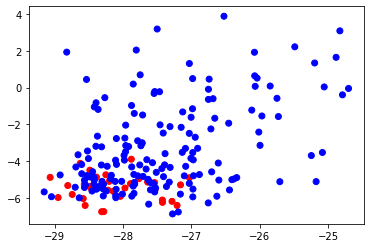

In [7]:
csp_data, labels = decoder.feature_transform();
train_data, test_data, labels_train, labels_test = train_test_split(data, labels);
plt.scatter(csp_data[:,0],csp_data[:,1],color=np.array(["red", "blue"])[np.where(labels == 1, 0, 1)])

In [8]:

lda = LDADecoder();
decoder.train(csp_data, labels, classifier=lda);
print('Accuracy of LDA classifier {}'.format(decoder.predict(csp_data, labels)));

Accuracy of LDA classifier 0.84


## CrossValidation and Extension

we will use the `SVM` to classify our data

In [9]:

clf_svm = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='linear', C=1));
scores = cross_val_score(clf_svm, data, labels, cv=5);
for i in range(len(scores)):   
    print('Accuracy of ' + str(i+1) + 'th fold is ' + str(scores[i]));
print('Mean accuracy {}'.format(np.mean(scores)));

Accuracy of 1th fold is 0.85
Accuracy of 2th fold is 0.85
Accuracy of 3th fold is 0.85
Accuracy of 4th fold is 0.825
Accuracy of 5th fold is 0.825
Mean accuracy 0.8400000000000001


## Hyperparameter Optimization

In [10]:
#svm
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42));
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True);

In [11]:
gs_cv_svm.fit(train_data, labels_train);
print('Best Parameters: {}'.format(gs_cv_svm.best_params_));
print('Best Score: {}'.format(gs_cv_svm.best_score_));

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.8466666666666667


## Evaluation

In [12]:
#Prediction
predictions_svm = gs_cv_svm.predict(test_data);

#Evaluate
report_svm = classification_report(labels_test, predictions_svm)
print('SVM Clasification Report:\n {}'.format(report_svm));

acc_svm = accuracy_score(labels_test, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm));

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm));

SVM Clasification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.82      1.00      0.90        41

    accuracy                           0.82        50
   macro avg       0.41      0.50      0.45        50
weighted avg       0.67      0.82      0.74        50

Accuracy of SVM model: 0.82
Precision: 0.41, Recall: 0.5, f1-score:0.45054945054945056


# Classify Over time

In [13]:
timeDecode = mne.decoding.SlidingEstimator(clf_svm)
epch_train = epoch_train.load_data().copy()
scores = mne.decoding.cross_val_multiscore(timeDecode, epch_train.get_data(), labels, cv=StratifiedKFold(n_splits=5), n_jobs=2)
print('Accuracy score {}'.format(np.mean(scores)));

Accuracy score 0.8272776572668112


Plotting scores over time

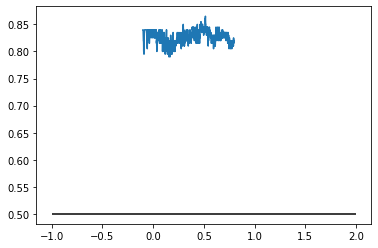

In [14]:
plt.plot(epch_train.times,scores.mean(axis=0))
plt.hlines(0.5,-1,2,'k')

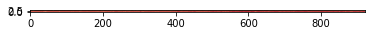

In [15]:
scores.shape
im = plt.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',vmin=0.2, vmax=1)
# plt.colorbar()

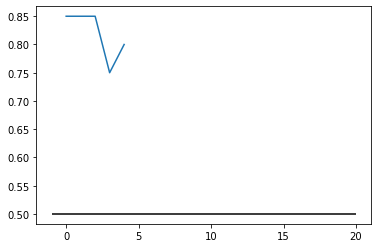

In [16]:
plt.plot(np.diag(scores))
plt.hlines(0.5,-1,20,'k')

In [17]:

clrs = SKLearnPipelineDecoder(clf_svm)
epoch_train = erp.epochs['stimulus/B']
epoch_train = epoch_train.load_data().copy()
clrs.fit(epoch_train, labels)
scores = clrs.predict(w_size=1)
scores
# plt.plot(clrs.timeVec,scores,'o-')
# plt.hlines(0.5,-1,4,'k')

array([], dtype=float64)

In [18]:
epoch_train = erp.epochs['stimulus']
epoch_train = epoch_train.load_data().copy()

decoder = Decoding(epoch_train)
_, labels = decoder.get_train(channels=['Cz', 'CPz'])
labels = decoder.labels_transform()

clf_svm = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='linear', C=1))
clrs = SKLearnPipelineDecoder(clf_svm)
# clrs
clrs.fit(epoch_train, labels)
scores = clrs.predict(w_size=1)
scores

array([], dtype=float64)

In [19]:
print(scores)

[]


# Multiple Subjects

In [20]:
pipeline.load_multiple_subjects(40, preload=True)
# pipeline.set_custom_events_mapping(task='P3')
pipeline.apply_resampling(256)
erp = ERPAnalysis(-0.1, 0.8)
pipeline.compute_epochs(erp)

100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


In [21]:
epoch_train = erp.epochs['stimulus'].copy()
decoder = Decoding(epoch_train)
data, labels = decoder.get_train(channels=['Cz', 'CPz'])

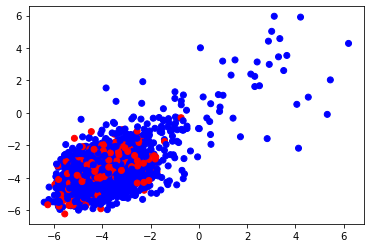

In [22]:
csp_data, labels = decoder.feature_transform();
train_data, test_data, labels_train, labels_test = train_test_split(data, labels);
plt.scatter(csp_data[:,0],csp_data[:,1],color=np.array(["red", "blue"])[np.where(labels == 1, 0, 1)])

In [23]:
lda = LDADecoder();
decoder.train(csp_data, labels, classifier=lda);
print('Accuracy of LDA classifier {}'.format(decoder.predict(csp_data, labels)));

Accuracy of LDA classifier 0.8674762407602957


In [24]:

clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42));
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True);
gs_cv_svm.fit(train_data, labels_train);
print('Best Parameters: {}'.format(gs_cv_svm.best_params_));
print('Best Score: {}'.format(gs_cv_svm.best_score_));

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.8725352112676056


In [25]:
stim_data = decoder.get_all_stim()
train_data_A, test_data_A, labels_train_A, labels_test_A = train_test_split(stim_data['A']['data'].mean(axis=2), stim_data['A']['labels'], test_size=0.3, random_state=42)
train_data_B, test_data_B, labels_train_B, labels_test_B = train_test_split(stim_data['B']['data'].mean(axis=2), stim_data['B']['labels'], test_size=0.3, random_state=42)
train_data_C, test_data_C, labels_train_C, labels_test_C = train_test_split(stim_data['C']['data'].mean(axis=2), stim_data['C']['labels'], test_size=0.3, random_state=42)
train_data_D, test_data_D, labels_train_D, labels_test_D = train_test_split(stim_data['D']['data'].mean(axis=2), stim_data['D']['labels'], test_size=0.3, random_state=42)
train_data_E, test_data_E, labels_train_E, labels_test_E = train_test_split(stim_data['E']['data'].mean(axis=2), stim_data['E']['labels'], test_size=0.3, random_state=42)

In [31]:

# Linear Discriminant Analysis
scores= []
lda = LDAPipleline(train_data_A, labels_train_A, test_data_A, labels_test_A)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = LDAPipleline(train_data_B, labels_train_B, test_data_B, labels_test_B)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = LDAPipleline(train_data_C, labels_train_C, test_data_A, labels_test_C)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = LDAPipleline(train_data_D, labels_train_D, test_data_D, labels_test_D)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = LDAPipleline(train_data_E, labels_train_E, test_data_E, labels_test_E)
lda.fit()
lda.predict()
scores.append(lda.evaluate())

LDA Clasification Report:
               precision    recall  f1-score   support

        Rare       0.22      0.08      0.12        25
    Frequent       0.79      0.93      0.85        95

    accuracy                           0.75       120
   macro avg       0.51      0.50      0.49       120
weighted avg       0.67      0.75      0.70       120

Accuracy of LDA model: 0.75
Precision: 0.5075075075075075, Recall: 0.5031578947368421, f1-score:0.48600799543118217
LDA Clasification Report:
               precision    recall  f1-score   support

        Rare       0.21      0.12      0.16        24
    Frequent       0.78      0.87      0.82        84

    accuracy                           0.70       108
   macro avg       0.50      0.50      0.49       108
weighted avg       0.65      0.70      0.67       108

Accuracy of LDA model: 0.7037037037037037
Precision: 0.49544072948328266, Recall: 0.49702380952380953, f1-score:0.48905972797161446
LDA Clasification Report:
               pre

In [32]:
scores

[(0.75, 0.48600799543118217),
 (0.7037037037037037, 0.48905972797161446),
 (0.8, 0.48238677210639824),
 (0.7433628318584071, 0.4578990901571547),
 (0.8148148148148148, 0.49390815370196817)]